# Installing the necessary Packages

In [1]:
# ! pip install wordcloud
# ! pip install Pillow
# ! pip install nltk

# Importing necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re
import string
from textblob import TextBlob
import html
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

# Dowloading necessary Packages

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/slidarey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/slidarey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/slidarey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading in the Dataset files

In [4]:
# reading in the sentiment analysis dataset
df_sentiment = pd.read_csv('sentiment_analysis.csv')
df_sentiment.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [5]:
# reading in the canadian elections dtaaset
df_elections = pd.read_csv('Canadian_elections_2019.csv')
df_elections.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


# Part 1. Data cleaning

In this part, a function was created to clean the sentiment_analysis.csv and Candian_elections_2019.csv datasets to prepare them for analysis. The function removes the HTML tags and attributes, HTML character codes, all URLs, all stopwords, converts all characters to lowercase and other miscellaneous characters such as:

    - "\n": new lines
    - "b"", "b'": byte strings
    - "\xf0\x9f\": Unicode Hex Characters

Stopwords are common words that do not add to the meaning of a sentence. The nltk library has a list of stopwords specific to each language. The ones specific to english language were used to remove the stopwords in the tweets.

### Defining a function to clean the two datasets

In [6]:
def data_cleaning(text, election_data=False):
    '''
    text: the input to clean
    election_data: the type of data we are cleaning
                    we dont want to remove hashtags(#)
    '''
    # converting characters to lower case
    text = text.lower()

    # removing the html tags and attributes using beautifulSoup html.parser
    soup=BeautifulSoup(text,'html.parser')
    text =  soup.get_text()

    # replacing the html character codes with ASCII equivalent
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')

    # removing the URLs
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'www\S+', '', text)

    # removing twitter mentions
    text = re.sub(r'@\w+', '', text)    

    # removing trailing and leading whitespaces
    text = re.sub(r'\s+',' ',text)

    # removing all non alphabet if we are not cleaning election data
    # we are not removing hashtags(#) for election data
    if not election_data:
        text=re.sub(r'[^a-zA-Z ]+', '', text)
    else:
        # removing hex characters
        text = re.sub('\bx[\w\d]+', '', text)
        # removing apostrophes with s ('s)
        text = re.sub(r'\'s', 's', text)
        # removing new lines characters
        text = re.sub(r'\\n', ' ', text)
        # removing possible miscellanous characters from election data
        text = re.sub(r'\||\'|\\|-|b"|b\'', '', text)
        # removing full stops
        text = re.sub(r'\.\b', '', text) 

    # removing stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(x for x in text.split() if x not in stop_words)

    return text

### Cleaning `sentiment_analysis.csv` dataset

In [7]:
df_sentiment['cleaned_text'] = df_sentiment['text'].apply(data_cleaning)
df_sentiment.head()

,ID,text,label,cleaned_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeders crow...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,rt congratulations pakistan becoming notesttea...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,rt september taking maine mendozas surprise th...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,rt newly painted walls thanks million custodia...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,rt excited announce july feschotte lab relocat...


### Cleaning `Canadian_elections_2019.csv` dataset

In [8]:
df_elections['cleaned_text'] = df_elections['text'].apply(data_cleaning, args=(True,))
df_elections.head()

,sentiment,negative_reason,text,cleaned_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","instead suggestion, agree #canadian #women tru..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#allwomanspacewalk real! #etobicokenorth #city...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#brantford going cost $94 billion next 4 years...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#canada #canadaelection2019 #canadavotes #elxn...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#canada #taxpayers sick & tired hard earned $ ...


### Lemmatizing the two datasets

The process of lemmatizing was done to reduce the number of unique words because of the TF-IDF and Word Frequency techniques that were used later in this notebook.

Lemmatization was selected over stemming for preprocessing the cleaned text as it leads to higher precision for sentiment analysis.

In [9]:
from textblob import Word
df_sentiment['lemmatized_text'] = df_sentiment['cleaned_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
df_sentiment.head()

,ID,text,label,cleaned_text,lemmatized_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeders crow...,josh jenkins looking forward tab breeder crown...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,rt congratulations pakistan becoming notesttea...,rt congratulation pakistan becoming notestteam...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,rt september taking maine mendozas surprise th...,rt september taking maine mendozas surprise th...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,rt newly painted walls thanks million custodia...,rt newly painted wall thanks million custodial...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,rt excited announce july feschotte lab relocat...,rt excited announce july feschotte lab relocat...


In [10]:
df_elections['lemmatized_text'] = df_elections['cleaned_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
df_elections.head()

,sentiment,negative_reason,text,cleaned_text,lemmatized_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","instead suggestion, agree #canadian #women tru...","instead suggestion, agree #canadian #women tru..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#allwomanspacewalk real! #etobicokenorth #city...,#allwomanspacewalk real! #etobicokenorth #city...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#brantford going cost $94 billion next 4 years...,#brantford going cost $94 billion next 4 years...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#canada #canadaelection2019 #canadavotes #elxn...,#canada #canadaelection2019 #canadavotes #elxn...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#canada #taxpayers sick & tired hard earned $ ...,#canada #taxpayers sick & tired hard earned $ ...


### Number of rows with empty tweets for the two datasets.

In [11]:
print('Number of rows with empty text for the sentiment_analysis dataset: {}'.format(df_sentiment['lemmatized_text'].isnull().sum()))
print('Number of rows with empty text for the canadaian_election dataset: {}'.format(df_elections['lemmatized_text'].isnull().sum()))

Number of rows with empty text for the sentiment_analysis dataset: 0
Number of rows with empty text for the canadaian_election dataset: 0


We have no empty tweets for the two datasets.

# Part 2. Exploratory Data Analysis

A simple procedure was implemented to assign a political party label to each of the tweets. The political parties considered are Liberal, Conservative, NDP and None. 

Also, this section presents Exploratory Data Analysis (EDA) on both of the datasets (generic tweets and Canadian elections tweets).

### Procedure for determining the political party

Some random rows were explored for hashtags and words that are related to each political parties. The related words found for each party are listed below:

1. Liberal Party
 - leaders: Justin Trudeau
 - HashTags: trudeaumustgo, chooseforward, uptoyouth, libconcorruption, voting_liberal, teamtrudeau, lib
 - other keywords: justin, trudeau, liberal
 - acronyms: lpc, plc
 
2. Conservative Party
 - leaders: Andrew Scheer
 - other keywords: conservative, andrew, scheer, cpc_hq
 - acronyms: cpc, pcc
 
3. New Democratic
 - leaders: Jagmeet Singh
 - other keywords: newdemocratic, jagmeet, singh, uprisingh
 - acronyms: npd, ndp




In [12]:
# keywords and hashtags peculiar to each party
liberal_keys = 'justin|trudeau|justintrudeau|liberal|chooseforward|uptoyouth|libconcorruption|plc|voting_liberal|teamtrudeau|lib|lpc|plc'
conservative_keys = 'conservative|andrew|scheer|cpc|pcc|cpc_hq'
ndp_keys = 'newdemocratic|jagmeet|singh|npd|ndp|thejagmeetsingh|uprisingh'

In [13]:
df_elections['liberal'] = df_elections['lemmatized_text'].str.contains(liberal_keys)
df_elections['conservative'] = df_elections['lemmatized_text'].str.contains(conservative_keys)
df_elections['ndp'] = df_elections['lemmatized_text'].str.contains(ndp_keys)

In [14]:
# Counts for number of tweet related to each party
liberal_count = df_elections['liberal'].sum()
conservative_count = df_elections['conservative'].sum()
ndp_count = df_elections['ndp'].sum()

# Tweets that aren't associated with any party
none_party = df_elections[['liberal', 'conservative', 'ndp']].sum(axis=1)
none_count = (none_party==0).sum()

print('Number of tweets about liberal party: {}'.format(liberal_count))
print('Number of tweets about conservative party: {}'.format(conservative_count))
print('Number of tweets about ndp party: {}'.format(ndp_count))
print('Number of tweets that are particular to any party: {}'.format(none_count))

Number of tweets about liberal party: 608
Number of tweets about conservative party: 588
Number of tweets about ndp party: 206
Number of tweets that are particular to any party: 1031


Almost half of the entire canadian election tweets were not related to any party. Exactly `608` tweets were related to the Liberal parties, `588` tweets were about the Conservative party and just `206` for the New Democratic Party.

## Visualization

### Word cloud visualization for the sentiment analysis dataset

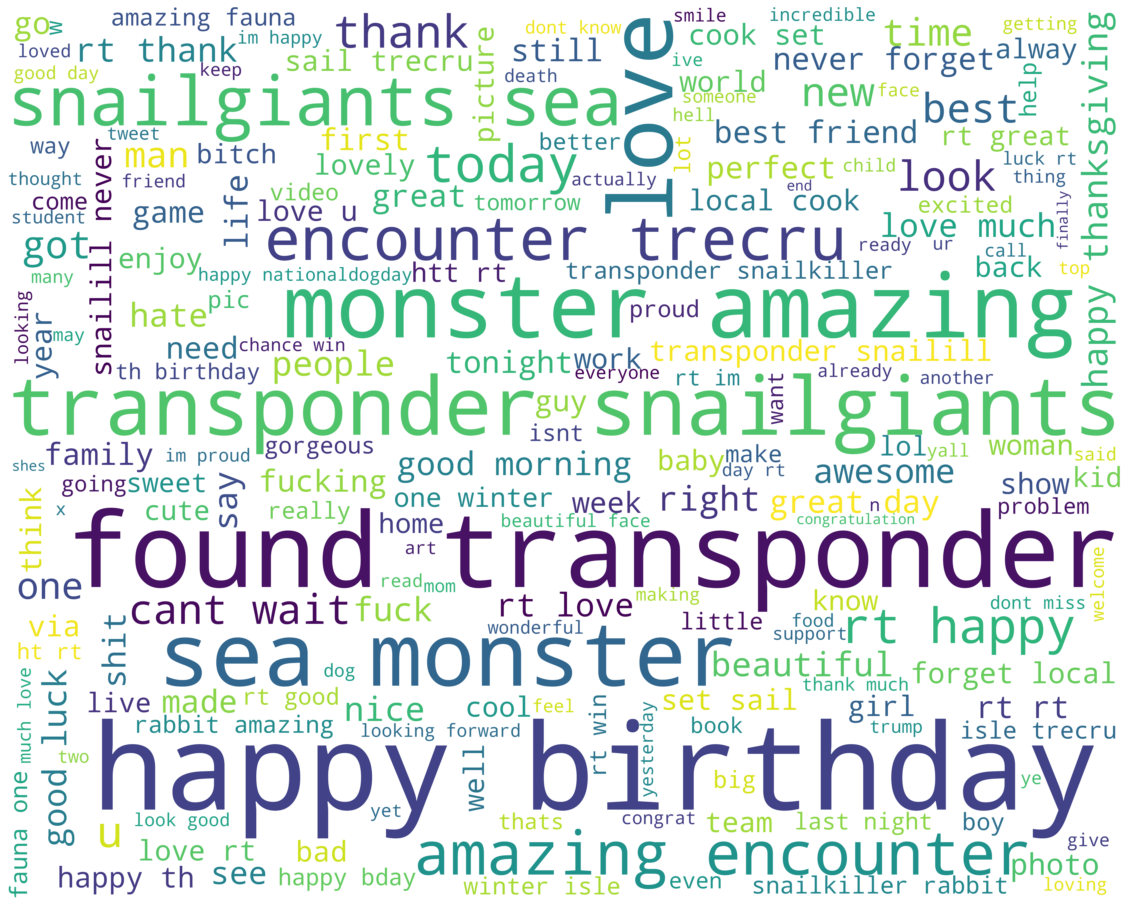

In [15]:
# create wordcloud on the lemmtised text
from textblob import TextBlob
# text = " ".join(each_text for each_text in df_elections['lemmatized_text'])
text = ' '.join(each_text for each_text in df_sentiment['lemmatized_text'].astype(str))
wordcloud = WordCloud(width = 5000, height = 4000, background_color="white").generate(str(text))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The common words in the sentiment analysis are not related to elections. Common words are happy birthday, transponder, snailgiants sea, encounter, amazing encounter. This is an indication that public opinion on twitter has little to no connection with the 2019 Canadian election.

### Word cloud visualization for the candian elections dataset.

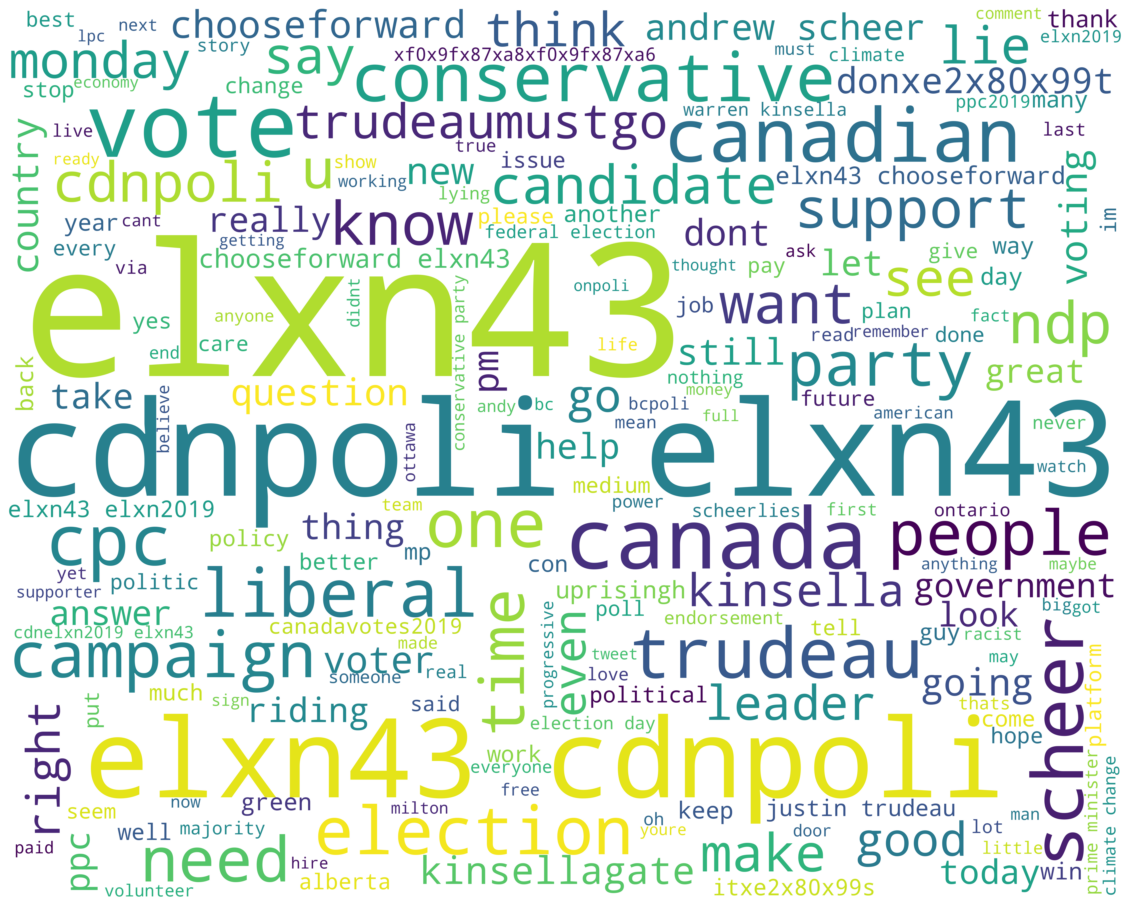

In [16]:
# create wordcloud on the lemmtised text
from textblob import TextBlob
# text = " ".join(each_text for each_text in df_elections['lemmatized_text'])
text = ' '.join(each_text for each_text in df_elections['lemmatized_text'].astype(str))
wordcloud = WordCloud(width = 5000, height = 4000, background_color="white").generate(str(text))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud of the Canadian election dataset shows common words like elxn43 (43rd election in canada), cdnpoli (Canada Politics), slogans for different parties (trudeaumustgo, scheerlies, uprisingh).

### **BONUS**:The number of positive & negative tweets that relate to each party.

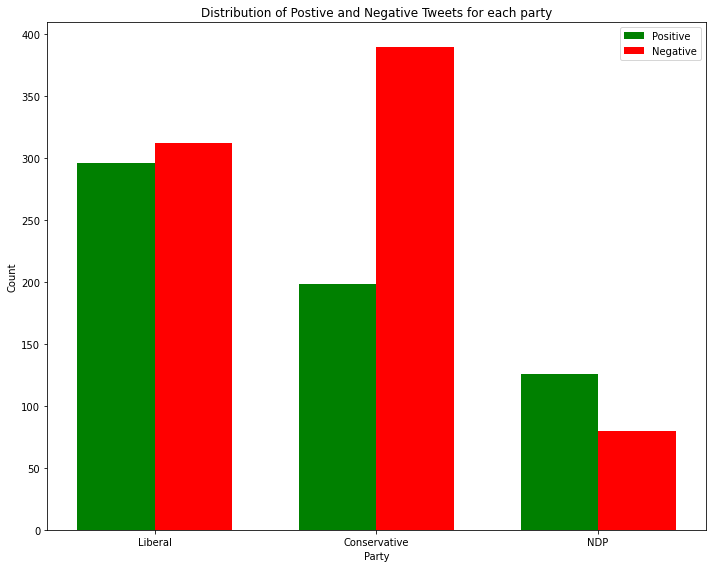

In [17]:
# plot the bar chart
width = 0.35
x = np.arange(3)  # the label locations

positive = df_elections[df_elections['sentiment']=='positive']
pos_liberal = positive['liberal'].sum()
pos_conservative = positive['conservative'].sum()
pos_ndp = positive['ndp'].sum()
pos_total = [pos_liberal, pos_conservative, pos_ndp]

negative = df_elections[df_elections['sentiment']=='negative']
neg_liberal = negative['liberal'].sum()
neg_conservative = negative['conservative'].sum()
neg_ndp = negative['ndp'].sum()
neg_total = [neg_liberal, neg_conservative, neg_ndp]

plt.figure(figsize=(10,8))
plt.bar(x - width/2, pos_total, label='Positive', width=width, color='green')
plt.bar(x + width/2, neg_total, label='Negative', width=width, color='red')
plt.title('Distribution of Postive and Negative Tweets for each party')
plt.xticks(x, ('Liberal', 'Conservative', 'NDP'))
plt.xlabel('Party')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

The negative tweets of the Conservative Party double their positive tweets. There are few tweets about the New Democratic Party as compared to the other two parties but most of them are positive. The count of the Liberal Party negative tweets is slightly more than its positive tweets.

# Part 3. Model Preparation

In this part, the Bag of Words (word frequency) and Term Frequency - Inverse Document Frequency (TF-IDF) features for the sentiment analysis dataset was generated to aid the training of the classification models in part 4.

### Bag of Words (Word Frequency) features creation.

The bag of words technique describes the frequency of words within a row. It assumes that the most important keywords occur more often than words that are not.

The bag of words feature was created using the `CountVectorizer` function from `sklearn` library before splitting the dataset into training and test set.

The number of BoW features was limited to 1000 to increase the computational time while training the classification models.

The technique is performed on the lemmatized text since the inflected words have been reduced to their word stem which will result to more varieties of words for the 1000 features.

In [18]:
# create a word frequency feature
count_vectorizer = CountVectorizer(max_features=1000)
wf_vector = count_vectorizer.fit_transform(df_sentiment['lemmatized_text'])

X_wf_data = wf_vector
y_wf_data = df_sentiment['label']
X_wf_train, X_wf_test, y_wf_train, y_wf_test = train_test_split(X_wf_data, y_wf_data, random_state=0, test_size=0.3)

### TF-IDF features creation.

The TF-IDF technique evaluates how relevant a word is to a document in a collection of documents. The idea here is that words that appear often are not important while words that appear less frequent contribute more to the overall importance.  

The `TfidfVectorizer` function was used for creating the features before splitting the datasets. Also, the maximum features generated was limited to 1000 for computational reasons.

In [19]:
# create a tf-idf feature
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vector = tfidf_vectorizer.fit_transform(df_sentiment['lemmatized_text'])

X_tfidf_data = tfidf_vector
y_tfidf_data = df_sentiment['label']
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf_data, y_tfidf_data, random_state=0, test_size=0.3)

# Part 4. Model Implementation

In this section, 7 types of classification algorithms were trained (`Logistic Reggression`, `k-NN`, `Naive Bayes`, `SVM(LinearSVC)`, `Decision Trees`, `Random Forest`, and `XGBoost`) on the `Word Frequency` features and `TF-IDF` features of the lemmatized generic tweets (`df_sentiment['lemmatized_text']`).

The goal here is to select the model with the best performance from the sentiment analysis and use it for predicting the sentiments in the Canadian election dataset.

### Defining a function to train a model on Word Frequency and TF_IDF Features

In [20]:
def train_model(model):
    '''
    This function returns the accuracy of the model
    trained on word frequency and TF-IDF features 
    '''
    # training on word frequency feature
    model.fit(X_wf_train, y_wf_train)
    wf_model_score = round(model.score(X_wf_test, y_wf_test), 4)

    # training on tf-idf feature
    model.fit(X_tfidf_train, y_tfidf_train)
    tfidf_model_score = round(model.score(X_tfidf_test, y_tfidf_test), 4)

    return wf_model_score, tfidf_model_score

### Logistic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_wf_score, logistic_tfidf_score = train_model(logistic_model)

print('Accuracy of logistic regression model on Word Frequency feature is: {}'.format(logistic_wf_score))
print('Accuracy of logistic regression model on TF-IDF feature is: {}'.format(logistic_tfidf_score))

Accuracy of logistic regression model on Word Frequency feature is: 0.9432
Accuracy of logistic regression model on TF-IDF feature is: 0.9424


### k-NN Model

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_wf_score, knn_tfidf_score = train_model(knn_model)

print('Accuracy of k-nearest neighbors model on Word Frequency feature is: {}'.format(knn_wf_score))
print('Accuracy of k-nearest neighbors model on TF-IDF feature is: {}'.format(knn_tfidf_score))

Accuracy of k-nearest neighbors model on Word Frequency feature is: 0.9142
Accuracy of k-nearest neighbors model on TF-IDF feature is: 0.8722


### Naive Bayes Model (Multinomial Naive Bayes)

In [23]:
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB()
mnb_wf_score, mnb_tfidf_score = train_model(mnb_model)

print('Accuracy of naive bayes model on Word Frequency feature is: {}'.format(mnb_wf_score))
print('Accuracy of naive bayes model on TF-IDF feature is: {}'.format(mnb_tfidf_score))

Accuracy of naive bayes model on Word Frequency feature is: 0.9075
Accuracy of naive bayes model on TF-IDF feature is: 0.8977


### SVM Model (LinearSVC)

In [24]:
from sklearn.svm import LinearSVC
linear_svc_model = LinearSVC()
linear_svc_wf_score, linear_svc_tfidf_score = train_model(linear_svc_model)

print('Accuracy of svm (linear svc) model on Word Frequency feature is: {}'.format(linear_svc_wf_score))
print('Accuracy of svm (linear svc) model on TF-IDF feature is: {}'.format(linear_svc_tfidf_score))

Accuracy of svm (linear svc) model on Word Frequency feature is: 0.9424
Accuracy of svm (linear svc) model on TF-IDF feature is: 0.9422


### Decision Tree Model

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_wf_score, dt_tfidf_score = train_model(dt_model)

print('Accuracy of decision tree model on Word Frequency feature is: {}'.format(dt_wf_score))
print('Accuracy of decision tree model on TF-IDF feature is: {}'.format(dt_tfidf_score))

Accuracy of decision tree model on Word Frequency feature is: 0.9273
Accuracy of decision tree model on TF-IDF feature is: 0.9291


### Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_wf_score, rf_tfidf_score = train_model(rf_model)

print('Accuracy of Random Forest Classifier model on Word Frequency feature is: {}'.format(rf_wf_score))
print('Accuracy of Random Forest Classifier model on TF-IDF feature is: {}'.format(rf_tfidf_score))

Accuracy of Random Forest Classifier model on Word Frequency feature is: 0.9416
Accuracy of Random Forest Classifier model on TF-IDF feature is: 0.9438


### XGBoost Model

In [27]:

from xgboost.sklearn import XGBClassifier
xgb_model = XGBClassifier()
xgb_wf_score, xgb_tfidf_score = train_model(xgb_model)

print('Accuracy of XGB Classifier model on Word Frequency feature is: {}'.format(xgb_wf_score))
print('Accuracy of XGB Classifier model on TF-IDF feature is: {}'.format(xgb_tfidf_score))

Accuracy of XGB Classifier model on Word Frequency feature is: 0.9244
Accuracy of XGB Classifier model on TF-IDF feature is: 0.9248


### Compiling the result of the models and selecting the best.

In [28]:
df_model_score = pd.DataFrame({'model':['Logistic Regression', 'k-NN', 'Naive Bayes(MutinomialNB)', 'SVM(LinearSVC)', 'Decision Tree', 'Random Forest', 'XGBoost'],
                               'bow_score':[logistic_wf_score, knn_wf_score, mnb_wf_score, linear_svc_wf_score, dt_wf_score, rf_wf_score, xgb_wf_score],
                               'tfidf_score':[logistic_tfidf_score, knn_tfidf_score, mnb_tfidf_score, linear_svc_tfidf_score, dt_tfidf_score, rf_tfidf_score, xgb_tfidf_score]})
df_model_score

,model,bow_score,tfidf_score
0,Logistic Regression,0.9432,0.9424
1,k-NN,0.9142,0.8722
2,Naive Bayes(MutinomialNB),0.9075,0.8977
3,SVM(LinearSVC),0.9424,0.9422
4,Decision Tree,0.9273,0.9291
5,Random Forest,0.9416,0.9438
6,XGBoost,0.9244,0.9248


The `RandomForestClassifier` has the best performance among the other trained models. It has an accuracy of `94.4%` on the `TF-IDF` feature of the generic tweets.

## Evaluate the model with best performance on the election dataset.

The model with the best performance in the sentiment analysis was used to predict the sentiments in the election dataset.



The dataset needs to be further prepared for further analysis:
 - The sentiment column of the data was encoded to `1s` and `0s`.
 - The hashtag words and other punctuations were removed.

In [29]:
# further preparing the ca the remove punctuations
df_elections['preprocessed_text'] = df_elections['lemmatized_text'].replace('#[\d\w]+', '', regex=True)
df_elections['preprocessed_text'] = df_elections['preprocessed_text'].str.replace('[{}]'.format(string.punctuation), '')

In [30]:
# encoding the sentiment column in the canadian election dataset
label_encoding = {'positive':1, 'negative':0}
df_elections['labels'] = df_elections['sentiment'].map(label_encoding)

In [31]:
# Re-training the best model on the 'generic tweets' that will be tested on the canadian election dataset
best_log_model = RandomForestClassifier()
best_log_model.fit(X_tfidf_train, y_tfidf_train)

RandomForestClassifier()

### Creating the TF-IDF Feature for the Canadian dataset.

In general, the model performed better on the TF-IDF features than the Word Frequency feature, therefore, the TF-IDF feature of the canadian elections dataset was created.

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
election_tfidf_vector = tfidf_vectorizer.fit_transform(df_elections['preprocessed_text'])

X_election_data = election_tfidf_vector
y_election_data = df_elections['labels']

election_score = best_log_model.score(X_election_data, y_election_data)
print('Accuracy of the best model on the canadian elections dataset is:',election_score)

Accuracy of the best model on the canadian elections dataset is: 0.5222691045475856


In [33]:
# preparing the data for visualization
df_elections['predicted_labels'] = best_log_model.predict(X_election_data)

lib_pos_target = df_elections[(df_elections['liberal'] == True) & (df_elections['labels'] == 1)].shape[0]
lib_neg_target = df_elections[(df_elections['liberal'] == True) & (df_elections['labels'] == 0)].shape[0]
lib_pos_predict = df_elections[(df_elections['liberal'] == True) & (df_elections['predicted_labels'] == 1)].shape[0]
lib_neg_predict = df_elections[(df_elections['liberal'] == True) & (df_elections['predicted_labels'] == 0)].shape[0]

con_pos_target = df_elections[(df_elections['conservative'] == True) & (df_elections['labels'] == 1)].shape[0]
con_neg_target = df_elections[(df_elections['conservative'] == True) & (df_elections['labels'] == 0)].shape[0]
con_pos_predict = df_elections[(df_elections['conservative'] == True) & (df_elections['predicted_labels'] == 1)].shape[0]
con_neg_predict = df_elections[(df_elections['conservative'] == True) & (df_elections['predicted_labels'] == 0)].shape[0]

ndp_pos_target = df_elections[(df_elections['ndp'] == True) & (df_elections['labels'] == 1)].shape[0]
ndp_neg_target = df_elections[(df_elections['ndp'] == True) & (df_elections['labels'] == 0)].shape[0]
ndp_pos_predict = df_elections[(df_elections['ndp'] == True) & (df_elections['predicted_labels'] == 1)].shape[0]
ndp_neg_predict = df_elections[(df_elections['ndp'] == True) & (df_elections['predicted_labels'] == 0)].shape[0]

pos_targets = [lib_pos_target, con_pos_target, ndp_pos_target]
neg_targets = [lib_neg_target, con_neg_target, ndp_neg_target]
pos_predicts = [lib_pos_predict, con_pos_predict, ndp_pos_predict]
neg_predicts = [lib_neg_predict, con_neg_predict, ndp_neg_predict]

### Visualize the sentiment prediction result and the true sentiment for each of the 3 parties.

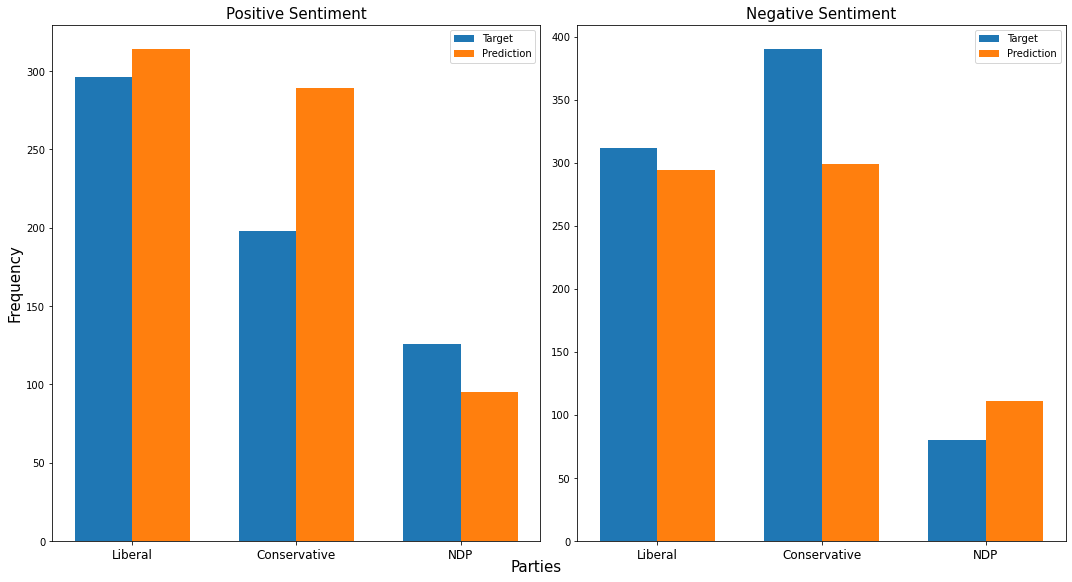

In [34]:
x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars
x_label = ['Liberal', 'Conservative', 'NDP']

# plotting the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

fig.text(0.5, 0, 'Parties', ha='center', fontsize=15)
# fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=15)

ax1.bar(x - width/2, pos_targets, label='Target', width=width)
ax1.bar(x + width/2, pos_predicts, label='Prediction', width=width)
# ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title('Positive Sentiment', fontsize=15)
ax1.set_xticks(x)
ax1.set_ylabel('Frequency', fontsize=15)
ax1.set_xticklabels(x_label, fontsize=12)

ax2.bar(x - width/2, neg_targets, label='Target', width=width)
ax2.bar(x + width/2, neg_predicts, label='Prediction', width=width)
# ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title('Negative Sentiment', fontsize=15)
ax2.set_xticks(x)
ax2.set_xticklabels(x_label, fontsize=12)

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

### **Question 4 Discussion of Result**

**How well do your predictions match the
sentiment labelled in the Canadian elections data?**
The accuracy of the model on the Canadian elections dataset is 52.4%. The model predicts more positive sentiments than there is for liberal and conservative and less positive sentiments for the NDP. This accuracy is as good as guessing and not good enough for electon analysis.


**Discuss
whether NLP analytics based on tweets is useful for political parties during election
campaigns.**
From the accuracy of the model and the visualization of the result, it can be concluded that NLP analytics based on tweets is not useful for political parties during an election as the results obtained are not a good indication of the public opinion about a particular party.
The approach of using hashtags/keywords to assign tweets to political parties. Using a sophisticated approach to assign a tweet to a political party might give us a better result. For example, designing a deep neural network that has very accuracy in assigning tweets to a particular model.
Also, most of the instances in the dataset are too generic to match any particular dataset. An example of a better dataset could include election tweets that are more related to political parties.

### Negative Reason Prediction for the Election Dataset.

Three multi-class classification models were trained to predict the negative reason of election tweets with negative sentiments. The three classifiers trained are listed below:

    Logistic Regression
    Naive Bayes (MultinomialNB)
    SVM (LinearSVC)


The negative tweets was first extracted from the canadian daataset then the TF-IDF feature of its `lemmatized_text` column was created. The number of features was limited to 1000.

In [35]:
# filtering out the positive sentiments from the canadian elections dataset
df_elections_negative = df_elections[df_elections['negative_reason'].notnull()].copy()

neg_election_vectorizer = TfidfVectorizer(max_features=1000)
neg_election_tfidf = neg_election_vectorizer.fit_transform(df_elections_negative['preprocessed_text'])

X_neg_election_data = neg_election_tfidf
y_neg_election_target = df_elections_negative['negative_reason']

### Train test split on the negative tweets election dataset.

In [36]:
# splitting the negative reason canadian dataset into train and test set
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_election_data, y_neg_election_target, test_size=0.3, random_state=0)

In [37]:
def train_model_neg_canadian(model):
    '''
    This function returns the accuracy of the model
    trained on TF-IDF features negative sentiment canadian elections 
    '''

    # training on tf-idf feature
    model.fit(X_neg_train, y_neg_train)
    tfidf_model_score = round(model.score(X_neg_test, y_neg_test), 4)
    return tfidf_model_score

### Logistic Regression Model

In [38]:
log_reason_model = LogisticRegression()
log_reason_score = train_model_neg_canadian(log_reason_model)
print('Logistic regression model score:', log_reason_score)

Logistic regression model score: 0.5149


### Naive Bayes (MultinomialNB)

In [39]:
mnb_reason_model = MultinomialNB()
mnb_reason_score = train_model_neg_canadian(mnb_reason_model)
print('Naive Bayes (MultinomialNB) model score:', mnb_reason_score)

Naive Bayes (MultinomialNB) model score: 0.5116


### SVM (LinearSVC)

In [40]:
linearSVC_reason_model = LinearSVC()
linearSVC_reason_score = train_model_neg_canadian(linearSVC_reason_model)
print('SVM LinearSVC model score:', linearSVC_reason_score)

SVM LinearSVC model score: 0.5479


### Accuracy of the models in predicting negative reasons

In [41]:
df_neg_score = pd.DataFrame({'model':['Logistic Regression', 'Naive Bayes(MutinomialNB)', 'SVM(LinearSVC)'],
                               'score':[log_reason_score, mnb_reason_score, linearSVC_reason_score]})
df_neg_score

,model,score
0,Logistic Regression,0.5149
1,Naive Bayes(MutinomialNB),0.5116
2,SVM(LinearSVC),0.5479


### Hyperparameter Tuning for the Best Model

The best model was the SVM LinearSVC model with accuracy of `54.8%`. The parameters of this model was further tuned to get the best performance out of the model.

In [42]:
params = {'C': [0.0001, 0.001, 0.1, 0.5, 0, 1, 2, 5, 10], 'penalty':['l1', 'l2']}
best_svm_model = LinearSVC()
grid_svm_model = GridSearchCV(best_svm_model, param_grid=params, scoring='accuracy')
best_svm_score = grid_svm_model.fit(X_neg_train, y_neg_train)

In [43]:
# parameters of the best SVM(LinearSVC model)
grid_svm_model.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [44]:
# training the best model
best_model = LinearSVC(C=0.5, penalty='l2')
best_model.fit(X_neg_train, y_neg_train)

LinearSVC(C=0.5)

In [45]:
print('The prediction accuracy of the parameterized LinearSVC model is:', round(best_model.score(X_neg_test, y_neg_test), 4))

The prediction accuracy of the parameterized LinearSVC model is: 0.538


The prediction accuracy of the parameterized LinearSVC model is: `53.8%`.

### Visualizing the result of the best model.

In [46]:
import itertools
def confusion_matrix_plot(cm, classes,normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10));
    plt.imshow(cm, interpolation='nearest', cmap='binary')
    plt.title(title, fontsize=13)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.tight_layout()
    plt.savefig('confusion_plot.png', dpi=300)

Cross Validation Accuracy: 0.52 (+/- 0.12)


                                     precision    recall  f1-score   support

                    Climate Problem       0.67      0.40      0.50        10
                            Economy       0.88      0.33      0.48        21
                             Others       0.53      0.66      0.59       123
                          Privilege       0.00      0.00      0.00         2
                            Scandal       0.58      0.59      0.59        83
                         Separation       0.00      0.00      0.00         4
                          Tell lies       0.39      0.35      0.37        48
Women Reproductive right and Racism       0.56      0.42      0.48        12

                           accuracy                           0.54       303
                          macro avg       0.45      0.34      0.38       303
                       weighted avg       0.54      0.54      0.53       303



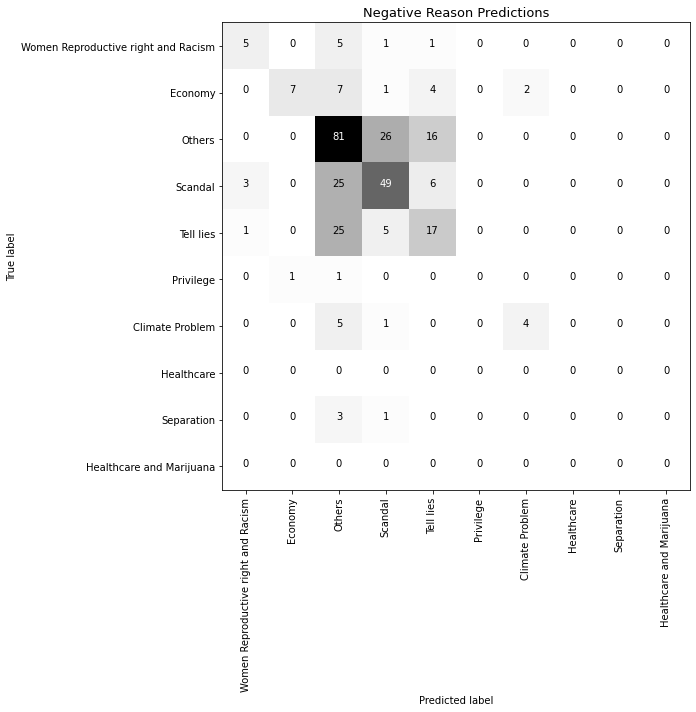

In [47]:
tick_label=df_elections_negative['negative_reason'].unique()

best_predictions = best_model.predict(X_neg_test)
best_predictions_series = pd.Series(best_predictions)

scores_multi = cross_val_score(best_model, X_neg_train, y_neg_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")

cm=confusion_matrix(y_neg_test, best_predictions_series, labels=tick_label)
confusion_matrix_plot(cm, classes=tick_label, title='Negative Reason Predictions')
print(classification_report(y_neg_test, best_predictions_series))

# Part 5. Results

### Discussion of result for the first model.

### **What can public opinion on Twitter tell us about the Canadian political landscape in 2019?** :

According to the analyses carried out and the results obtained, most tweeter users choose not to share their political standing as it can be observed that more than half of the tweets in the `2019 Canadian Election Dataset` were not peculiar to any political party.

Also, most of the election tweets were about the Liberal and Conservative parties, this indicates that the general public are mostly Liberals and Conservatives and this adds up as these two parties are the major political parties in Canada.


### **Public opinion about each party based on sentiment value**:

**Liberal:** The approximately equal amount of positive and negative sentiments about the Liberal party implies that half of the public are in support while the other (possibly other parties) are against the party's movement.  

**Conservative:** The negative sentiments about this party double the positive sentiments. This is an indication that the general public is not in support of this party's beliefs.

**NDP:** The NDP is the only party that has its positive sentiments to be substantially more than the negative sentiments.

The presence of so many negative tweets about the Conservatives might be an indication of why the Liberal political party are the winner of the 2019 election. The NDP have the potential to become the next winner if they can make themselves appear on more people's radar.


### Discussion of result for the second model.

### **Based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons:**

Among the three multi-class classification algorithm that was implemented, the SVM(LinearSVC) had the best performance with accuracy of `53.8%`. From the confusion matrix plotted, it can be observed that the model performed well in predicting the `Scandals and Others` negative reasons but didn't perform well on the other categories. This is due to **`imbalance dataset`** i.e the categories don't have approximately equal number of categories.


### **Ways to improve the accuracy of the models.**

**First model: Sentiment Prediction**
Using a better approach for assigning tweets to each political party and implementing a powerful machine learning model for sentiment prediction such as Neural nets might improve the accuracy.
       
**Second model: Negative Reason Prediction**
Getting more and approximately equal number of instances for each category of negative reasons i.e a balanced dataset will improve the accuracy of the model.